In [91]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
from parse_midi import Midi
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm, figure
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
set_matplotlib_formats('svg')
plt.rcParams['figure.dpi'] = 1200

import seaborn as sns
sns.set_style("darkgrid")


def filter_timerange(timed_notes, start, end):
    # returns all notes that occurr during start-end
    return timed_notes[(timed_notes.end > start) & (timed_notes.start < end)]


def get_onset_deltas(timed_notes):
    unique_onsets = pd.Series(timed_notes['start'].unique()).sort_values()
    onset_deltas = (unique_onsets - unique_onsets.shift())[1:]
    return onset_deltas[onset_deltas > 0.000001]


def calc_slice_duration(timed_notes, pgoal=0.05):
    onset_deltas = get_onset_deltas(timed_notes).sort_values().unique()
    onsets = timed_notes['start']
    slice_duration = 0
    p = 0
    while p <= pgoal:
        count = 0
        for t in onset_deltas:
            if slice_duration >= t:
                count += 1
        p = count / len(onset_deltas)
        slice_duration += 0.000001
    print('p:', p)
    return slice_duration




In [29]:

def hash_timed_notes(timed_notes):
    return frozenset(timed_notes['midi'])

def slice_notes(timed_notes, slice_duration, k={}):
    notes_duration = max(timed_notes['end']) - min(timed_notes['start'])
    num_slices = int(notes_duration // slice_duration) + 1
    slices = {}
    for t in range(num_slices):
        start = slice_duration * t
        end = slice_duration * (t + 1)
        
        tr = filter_timerange(timed_notes, start, end).reset_index()
        if len(tr) > 0:
            tr = tr.drop(columns=['start', 'end', 'vel'])
            tr_hash = hash_timed_notes(tr)
            _id = len(k.keys())
            if tr_hash in k:
                _id = k[tr_hash]
            k[tr_hash] = _id
            tr['slice_id'] = _id
            slices[_id] = tr

    slice_df = pd.concat(slices)
    return slice_df, k
    
    
midi_dir = './midi_files'
file_paths = [join(midi_dir, x) for x in listdir(midi_dir)]
print('Reading %s midi files...' % len(file_paths))


midi_objects = []
all_data = []


for i, fp in enumerate(file_paths[:5]):
    print('>>>', fp)
    mid = Midi.from_file(fp)
    midi_objects.append(mid)
    all_data += mid.note_times()

all_data = pd.DataFrame(all_data)
all_data

Reading 21 midi files...
>>> ./midi_files/mz_545_3.mid
>>> ./midi_files/mz_333_2.mid
>>> ./midi_files/mz_332_1.mid
>>> ./midi_files/mz_545_1.mid
>>> ./midi_files/mz_311_1.mid


,start,end,midi,vel
0,0.4608,0.5184,79,50
1,0.4608,0.5184,76,42
2,0.6912,0.7488,79,43
3,0.6912,0.7488,76,36
4,0.9216,0.9792,57,30
...,...,...,...,...
14568,276.4800,277.4016,73,54
14569,276.4800,277.4016,67,45
14570,277.4016,277.8624,38,35
14571,277.4016,277.8624,74,42


In [33]:
word_duration = calc_slice_duration(all_data, 0.05)
sentences = {}
k = {}
for i, mid in enumerate(midi_objects):
    print('Reading Midi Object #', i)
    w, k = slice_notes(pd.DataFrame(mid.note_times()), word_duration, k=k)
    sentences[i] = w
    
sents = pd.concat(sentences)
sents

p: 0.06060606060606061
Reading Midi Object # 0
Reading Midi Object # 1
Reading Midi Object # 2
Reading Midi Object # 3
Reading Midi Object # 4


index  midi  slice_id
0 0    0    930    79         0
       1    931    76         0
  1    0    719    57         1
       1    720    60         1
       2    721    76         1
...         ...   ...       ...
4 3542 5   2968    74      3542
       6   2969    66      3542
  3543 0   2967    38      3543
       1   2968    74      3543
       2   2969    66      3543

[14374 rows x 3 columns]

In [34]:
sents.groupby('slice_id').get_group(1)


index  midi  slice_id
0 1 0    719    57         1
    1    720    60         1
    2    721    76         1
    3    722    72         1
2 1 0   1891    76         1
    1   1892    72         1
    2   1893    57         1
    3   1894    60         1

In [93]:
# def plot_piano_roll(timed_notes, axis, color=None):
#     velocity_map = cm.magma(np.linspace(0,1,90))
#     min_width = 0.25

#     for _, note in timed_notes.iterrows():
#         width = max(min_width, note['end'] - note['start'])
#         tr = (note['start'], note['start'] + width)
#         midi_note = note['midi']
#         vel = int(note['vel'])
#         c = color if color is not None else velocity_map[vel]
#         axis.plot(tr, [midi_note, midi_note], lw=5, solid_capstyle='butt', color=c)

        
# _, ax = plt.subplots(figsize=(8,4))
# plot_piano_roll(sents[:500], ax)

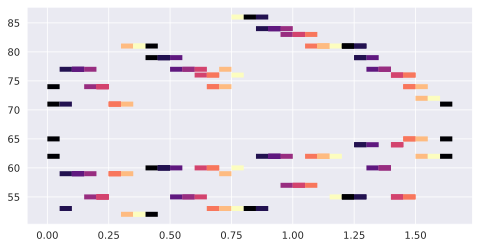

In [100]:

def plot_piano_word(words, axis, color=None):
    velocity_map = cm.magma(np.linspace(0,1,8))
    slice_duration = 0.05
    for i, sid in enumerate(words['slice_id'].unique()):
        word = sents[sents['slice_id'] == sid]
        c = color if color is not None else velocity_map[i % 8]
        for midi_note in word['midi']:
            axis.plot([
                i * slice_duration,
                (i + 1) * slice_duration
            ], [midi_note, midi_note], lw=5, solid_capstyle='butt', color=c)


_, ax = plt.subplots(figsize=(8,4))

for i in range(1):
    plot_piano_word(
        sents.loc[0][1000:1100],
        ax) 



In [89]:
all_slices = []
for s in sents['slice_id']:
    immut_slice = hash_timed_notes(
        sents.groupby('slice_id').get_group(s))
    all_slices.append(immut_slice)

all_slices[:10]

[frozenset({76, 79}),
 frozenset({76, 79}),
 frozenset({57, 60, 72, 76}),
 frozenset({57, 60, 72, 76}),
 frozenset({57, 60, 72, 76}),
 frozenset({57, 60, 72, 76}),
 frozenset({72, 76}),
 frozenset({72, 76}),
 frozenset({57, 60}),
 frozenset({57, 60})]

In [40]:
print(len(all_slices))
print(len(set(all_slices)))

14374
3544


In [88]:

compressed = sents['slice_id'].values
